In [ ]:
w!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The dataset shareable link

#new stylo data
#link = 'https://drive.google.com/open?id=15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l'
link = 'https://drive.google.com/file/d/1LEbg13-KBZzHmIWAv9SnthGUzjvcbJuA/'
id= '1LEbg13-KBZzHmIWAv9SnthGUzjvcbJuA'

#fluff, id = link.split('=')
filename = 'stylo-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)


#raw_data_link = 'https://drive.google.com/file/d/1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ/view?usp=sharing'
raw_id = '1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ'
#fluff, id = raw_data_link.split('=')
print(raw_id)
raw_filename = 'raw_data.csv'
downloaded = drive.CreateFile({'id':raw_id})
downloaded.GetContentFile(raw_filename)


#news stylo dataset
news_id = '15zZXsks6cI0FY4vpL555lBQSBr1QyjT4'
news_filename = 'news-data.csv'
downloaded = drive.CreateFile({'id':news_id})
downloaded.GetContentFile(news_filename)

1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ


In [ ]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectPercentile, SelectFwe, RFECV,  chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer

!pip install -U keras
!pip install -U shap
!pip install -U eli5
import shap
import eli5

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import InputLayer, Embedding, Conv1D, MaxPool1D, Dense, Flatten, Dropout, GRU, LSTM, Input
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras import Sequential
from keras.initializers import Constant

from pprint import pprint

from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*PS: Para baixar os arquivos do Google Drive, é preciso clicar no link que irá aparecer no console, aceitar as permissões do Drive e em seguida colar o código de verificação no local indicado (console)*

*Sem o arquivo não é possível executar os outros trechos do notebook*

In [ ]:
# read dataset
df = pd.read_csv(filename)
raw_df = pd.read_csv(raw_filename)
df_news = pd.read_csv(news_filename)


# Remove single class entries (We need at least 3 samples of an author)#
df = df.groupby('Author').filter(lambda x: len(x) > 3)
raw_df = raw_df.groupby('Author').filter(lambda x: len(x) > 3)

In [ ]:
#Separate data from labels

y = df.pop('Author')
y_raw = raw_df.pop('Author')
y_news = df_news.pop('Author')

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(y_raw)
encoded_raw_Y = le.transform(y_raw)

le.fit(y_news)
encoded_y_news = le.transform(y_news)

In [ ]:
raw_df

In [ ]:
# Feature selection

# Baseline (Variance threshold):
threshold=(.01)
selector = VarianceThreshold(threshold)
selector.fit(df)

df.columns[selector.get_support(indices=True)] # 22 features, data has very low variance (features are mostly very close)

# selector.fit(df)

# df.columns[selector.get_support(indices=True)]

22

In [ ]:
# 50% better based on percentile using chi2 (37f)
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Monossilabas', 'Ponto', 'Virgulas',
       'Exclamacoes', 'DoisPontos', 'Citacoes', 'QuebrasDeLinha', 'Digitos',
       'PronomesPorPreposicao', 'Passado', 'EntAbstracao', 'EntAcontecimento',
       'EntCoisa', 'EntLocal', 'EntOrganizacao', 'EntObra', 'EntOutro',
       'EntPessoa', 'EntTempo', 'EntValor', 'GuiraudR', 'HerdanV', 'DugastU',
       'HonoresH', 'HapaxLegomenaLocal', 'BRFleshIndex', 'top 1-gram',
       'top 3-gram', 'top 4-gram', 'top 5-gram'],
      dtype='object')

In [ ]:
# 50% better based on percentile using chi2 (37f)
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df_news, y_news)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'Monossilabas', 'Ponto', 'Virgulas', 'Exclamacoes', 'DoisPontos',
       'Citacoes', 'QuebrasDeLinha', 'Adverbios', 'VerbosPtcp', 'Pronomes',
       'PronomesPorPreposicao', 'TermosNaoTageados', 'PrimeiraPessoa',
       'Presente', 'EntCoisa', 'EntObra', 'EntOutro', 'EntPessoa', 'EntTempo',
       'EntValor', 'GuiraudR', 'HerdanV', 'DugastU', 'PalavrasErroOrtografico',
       'HapaxLegomenaLocal', 'BRFleshIndex', 'PalavrasCapitalizadas',
       'top 1-gram', 'top 3-gram', 'top 4-gram', 'top 5-gram'],
      dtype='object')

In [ ]:
selector = SelectPercentile(percentile=50)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'FrequenciaDeParagrafos',
       'FrequenciaPalavrasDuplicadas', 'MediaSilabasPorPalavra',
       'Monossilabas', 'Ponto', 'Virgulas', 'Citacoes', 'QuebrasDeLinha',
       'Digitos', 'Adjetivos', 'Preposicoes', 'Conjuncoes',
       'TermosNaoTageados', 'PalavrasDeConteudo', 'GenMasc', 'GenFem',
       'SemGenero', 'TotalEntidadesNomeadas', 'HerdanC', 'DugastU', 'MaasA',
       'HonoresH', 'PalavrasErroOrtografico', 'HapaxLegomenaLocal',
       'PalavrasComunsTam2', 'StopWords', 'BRFleshIndex', 'Global hapax',
       'top 1-gram', 'top 3-gram', 'top 4-gram', 'top 5-gram'],
      dtype='object')

In [ ]:
selector = SelectPercentile(percentile=50)
selector.fit(df_news, y_news)
df_news.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'StdevSentencas',
       'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Monossilabas', 'Exclamacoes', 'Citacoes',
       'QuebrasDeLinha', 'Adverbios', 'Substantivos', 'Preposicoes',
       'VerbosPtcp', 'Pronomes', 'PronomesPorPreposicao', 'TermosNaoTageados',
       'PalavrasDeConteudo', 'FrasesVerbais', 'SemGenero', 'Singular',
       'TerceiraPessoa', 'Presente', 'Futuro', 'GuiraudR', 'HerdanV',
       'MedidaK', 'DugastU', 'MaasA', 'PalavrasErroOrtografico',
       'HapaxLegomenaLocal', 'PalavrasComunsTam4', 'StopWords',
       'PalavrasCapitalizadas', 'Global hapax', 'top 4-gram', 'top 5-gram'],
      dtype='object')

In [ ]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=74).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(35,'Score'))

                    Feature        Score
55                  HerdanV  3240.480483
4    TamanhoMedioParagrafos  2660.335980
5        StdevTamParagrafos  1373.072039
3            StdevSentencas   150.375319
0         DiversidadeLexica   138.597858
2     TamanhoMedioSentencas   126.791038
70               top 1-gram   114.339214
57                  DugastU    79.869125
13               DoisPontos    55.254317
11                 Virgulas    35.802381
15           QuebrasDeLinha    25.352158
12              Exclamacoes    25.096919
10                    Ponto    17.111885
53                 GuiraudR    15.582640
66             BRFleshIndex     9.122961
71               top 3-gram     6.813025
26    PronomesPorPreposicao     5.663002
72               top 4-gram     4.827784
73               top 5-gram     4.433602
1   TamanhoMedioDasPalavras     2.611150
59                 HonoresH     2.088297
61       HapaxLegomenaLocal     1.980219
44         EntAcontecimento     1.915102
49              

In [ ]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=74).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df_news.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(35,'Score'))

                    Feature        Score
55                  HerdanV  2688.503948
5        StdevTamParagrafos  1707.831479
4    TamanhoMedioParagrafos  1103.327474
2     TamanhoMedioSentencas   862.748893
12              Exclamacoes    59.697231
3            StdevSentencas    59.007230
0         DiversidadeLexica    37.698913
57                  DugastU    33.392403
53                 GuiraudR    22.573746
11                 Virgulas    21.582665
10                    Ponto    16.308883
13               DoisPontos    12.164414
70               top 1-gram    10.241280
26    PronomesPorPreposicao     6.568906
66             BRFleshIndex     4.978543
72               top 4-gram     2.430000
73               top 5-gram     2.430000
1   TamanhoMedioDasPalavras     1.791193
68    PalavrasCapitalizadas     0.921331
27        TermosNaoTageados     0.810441
71               top 3-gram     0.713333
37           PrimeiraPessoa     0.702100
9              Monossilabas     0.686709
49              

In [ ]:
# K-Best (f_classif)
best_k_features = SelectKBest(f_classif, k=54).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df_news.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(35,'Score'))

                    Feature      Score
72               top 4-gram  81.000000
73               top 5-gram  81.000000
12              Exclamacoes  19.089614
69             Global hapax  13.503812
53                 GuiraudR  13.162995
25                 Pronomes  12.735249
28       PalavrasDeConteudo  12.442170
27        TermosNaoTageados  12.376033
56                  MedidaK  12.152812
26    PronomesPorPreposicao  10.844617
1   TamanhoMedioDasPalavras  10.182217
18                Adverbios   9.488145
9              Monossilabas   9.470314
65                StopWords   9.293226
55                  HerdanV   9.033462
68    PalavrasCapitalizadas   8.862075
21              Preposicoes   8.457826
20             Substantivos   8.408751
6    FrequenciaDeParagrafos   8.297498
40                 Presente   7.427606
15           QuebrasDeLinha   7.420883
23               VerbosPtcp   6.958381
4    TamanhoMedioParagrafos   6.232976
38           TerceiraPessoa   6.224789
57                  Dugas

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#SelectFromModel will select those features which importance is greater than the mean importance of all the features by default
sel = SelectFromModel(ExtraTreesClassifier(n_estimators = 200, random_state=0))
sel.fit(df_news, y_news)
selected_feat= df.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)


30
Index(['TamanhoMedioDasPalavras', 'TamanhoMedioSentencas', 'StdevSentencas',
       'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Monossilabas', 'Ponto', 'Virgulas',
       'Exclamacoes', 'DoisPontos', 'QuebrasDeLinha', 'Adverbios',
       'Preposicoes', 'Pronomes', 'TermosNaoTageados', 'PalavrasDeConteudo',
       'GuiraudR', 'HerdanV', 'MedidaK', 'DugastU', 'MaasA',
       'PalavrasComunsTam3', 'PalavrasComunsTam4', 'StopWords',
       'PalavrasCapitalizadas', 'Global hapax', 'top 1-gram', 'top 4-gram',
       'top 5-gram'],
      dtype='object')


In [ ]:
clf = ExtraTreesClassifier(n_estimators = 200, random_state=0)
clf.fit(df, y)
#Pass the model instance along with the feature names to ELI5
eli5.show_weights(clf, feature_names=list(df.columns), top = 30)

Weight,Feature
0.0217 ± 0.0497,HerdanC
0.0211 ± 0.0457,Virgulas
0.0199 ± 0.0430,Digitos
0.0197 ± 0.0449,StopWords
0.0196 ± 0.0417,StdevSentencas
0.0187 ± 0.0400,Artigos
0.0184 ± 0.0419,DugastU
0.0183 ± 0.0428,MaasA
0.0179 ± 0.0446,HonoresH
0.0177 ± 0.0375,DiversidadeLexica


In [ ]:
encoded_y_news

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

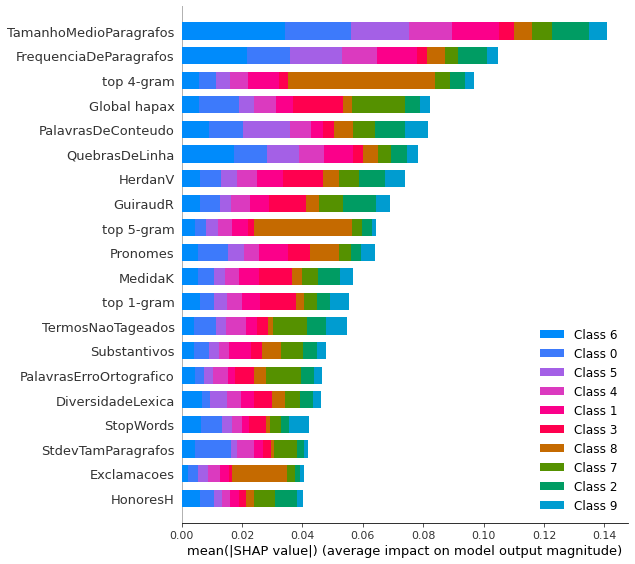

Optimal number of features news-dataset: 71
Optimal number of features students-dataset: 50


<Figure size 432x288 with 0 Axes>

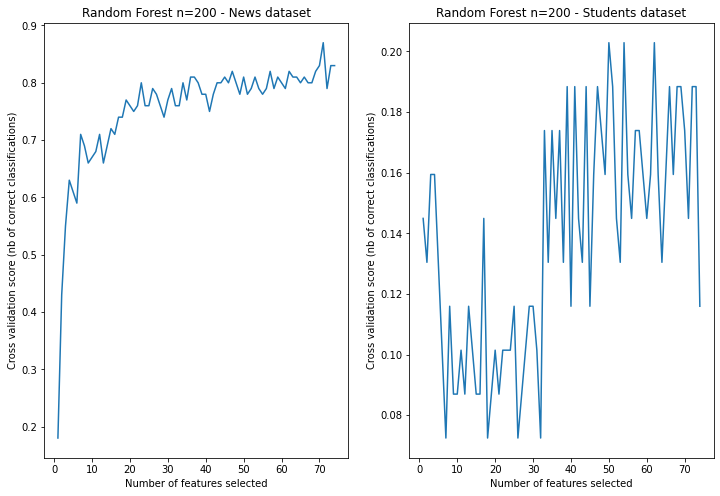

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create the RFE object and compute a cross-validated score.
rfc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features news-dataset: %d" % rfecv.n_features_)

rfecv2 = RFECV(estimator=rfc, step=1, cv=3,
              scoring='accuracy')
rfecv2.fit(df, y)

print("Optimal number of features students-dataset: %d" % rfecv2.n_features_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Random Forest n=200 - News dataset')

ax2.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
ax2.set_xlabel("Number of features selected")
ax2.set_ylabel("Cross validation score (nb of correct classifications)")
ax2.set_title('Random Forest n=200 - Students dataset')

plt.figure()

Optimal number of features : 34


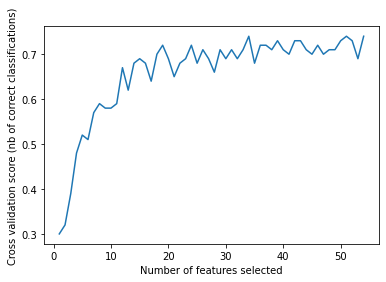

In [ ]:
svc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=5,
              scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# Visualize data
df.shape
df.head()
df.shape
raw_df.head()

,Text
1,respostas ecologia evolutiva retirar amostra p...
2,1 - competição membros espécies diferentes usa...
3,embora temática questão ambiental crescente an...
5,vem cada dia buscando entender relações estabe...
6,"pode-se dizer que, conservar dado habitat dada..."


In [ ]:
#stopwords = nltk.corpus.stopwords.words('portuguese')
raw_df['Text'] = raw_df['Text'].apply(lambda x: ' '.join([word for word in x.split()]))

In [ ]:
raw_df = raw_df.replace(to_replace ='\r', value = ' ', regex = True) 
raw_df = raw_df.replace(to_replace ='\n ', value = '\n', regex = True) 
raw_df = raw_df.replace(to_replace ='\n{2,*}', value = ' ', regex = True)

In [ ]:
raw_df['Text']

1      respostas ecologia evolutiva retirar uma amost...
2      1 - competição entre membros de espécies difer...
3      embora a temática questão ambiental esteja num...
5      a ciência vem a cada dia buscando entender as ...
6      pode-se dizer que, conservar um dado habitat o...
                             ...                        
92     referencial teórico: anuras ( bufonídeos ) ou ...
93     congregação santa dorotéia do brasil – – a seg...
94     congregação santa doroteia do brasil em ciênci...
95     disciplina: orientação e supervisão de estágio...
102    metodologia do ensino de ciências e de biologi...
Name: Text, Length: 69, dtype: object

In [ ]:
#X_idf = tfidf_transformer.fit_transform(raw_df['Text'])
X_tfidf = TfidfVectorizer().fit_transform(raw_df['Text'])

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3, random_state=42)
data = svd.fit_transform(X_tfidf) 

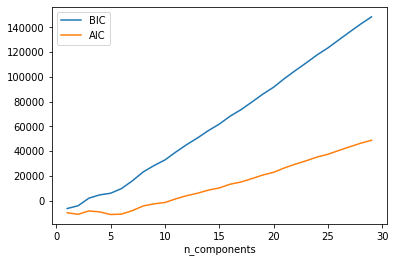

In [ ]:
gx = GaussianMixture()

#gx.fit(df)
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df) for n in n_components]
plt.plot(n_components, [m.bic(df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

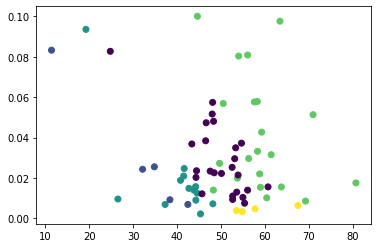

In [ ]:
gmm = GaussianMixture(n_components=5)
gmm.fit(df)
labels = gmm.predict(df.values)
plt.scatter(df.values[:, 0], df.values[:, 6], c=labels, cmap='viridis');

In [ ]:
scaler = StandardScaler()
# Fit on training set only.
x = scaler.fit_transform(df)

pca = PCA(0.95)
X = pca.fit_transform(x)

In [ ]:
#W2Vec tryout
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


# count_vect = CountVectorizer()
# word_count_vector = count_vect.fit_transform(raw_df['Text'])
 
# settings that you use for count vectorizer will go here
#tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
#tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(raw_df['Text'])

# tfidf_transformer = TfidfTransformer()
# X_raw = tfidf_transformer.fit_transform(X_train_counts)
#tfidf_vectorizer_vectors[0].to

# for train_index, test_index in kfold.split(X_raw, encoded_raw_Y):
#   X_train, y_train = X_raw[train_index], encoded_raw_Y[train_index]
#   X_test, y_test = X_raw[test_index], encoded_raw_Y[test_index]
#   print(X_raw[train_index])


X_train, X_test, y_train, y_test = train_test_split(raw_df['Text'], encoded_raw_Y, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')
#models = [AdaBoostClassifier(), BaggingClassifier(),ExtraTreesClassifier(), GradientBoostingClassifier(),
           #RandomForestClassifier(), SGDClassifier(), LinearSVC(), SVC(), BernoulliNB(), MultinomialNB(), MLPClassifier() ]

models = [ExtraTreesClassifier(), RandomForestClassifier(), SGDClassifier(), MultinomialNB(), MLPClassifier()]
names = ['extratrees', 'randomf', 'sgdclassfier','multinomialNB', 'mlp']

results = []
accuracies = {}
for idx, model in enumerate(models):
  for ngram in range(1,5):
    clf = make_pipeline(TfidfVectorizer(use_idf=True, stop_words = stopwords, ngram_range=(1, ngram)), model)
    accs = []
    for i in range(0, 10):
      scores = cross_validate(clf, raw_df['Text'], encoded_raw_Y, scoring=['accuracy'], cv=3, return_train_score=True)
      #print(np.mean(scores['test_accuracy']))
      #print(component, names[idx])
      #print(scores['test_accuracy'])
      mean = np.mean(scores['test_accuracy'])
    accs.append(mean)
    results.append((np.mean(accs), ngram, names[idx]))

print(results)
results

[(0.21739130434782608, 1, 'extratrees'), (0.24637681159420288, 2, 'extratrees'), (0.2028985507246377, 3, 'extratrees'), (0.2028985507246377, 4, 'extratrees'), (0.2318840579710145, 1, 'randomf'), (0.24637681159420288, 2, 'randomf'), (0.20289855072463767, 3, 'randomf'), (0.14492753623188406, 4, 'randomf'), (0.18840579710144925, 1, 'sgdclassfier'), (0.1884057971014493, 2, 'sgdclassfier'), (0.20289855072463767, 3, 'sgdclassfier'), (0.2028985507246377, 4, 'sgdclassfier'), (0.17391304347826086, 1, 'multinomialNB'), (0.14492753623188406, 2, 'multinomialNB'), (0.14492753623188406, 3, 'multinomialNB'), (0.14492753623188406, 4, 'multinomialNB'), (0.2318840579710145, 1, 'mlp'), (0.17391304347826086, 2, 'mlp'), (0.2028985507246377, 3, 'mlp'), (0.24637681159420288, 4, 'mlp')]


[(0.21739130434782608, 1, 'extratrees'),
 (0.24637681159420288, 2, 'extratrees'),
 (0.2028985507246377, 3, 'extratrees'),
 (0.2028985507246377, 4, 'extratrees'),
 (0.2318840579710145, 1, 'randomf'),
 (0.24637681159420288, 2, 'randomf'),
 (0.20289855072463767, 3, 'randomf'),
 (0.14492753623188406, 4, 'randomf'),
 (0.18840579710144925, 1, 'sgdclassfier'),
 (0.1884057971014493, 2, 'sgdclassfier'),
 (0.20289855072463767, 3, 'sgdclassfier'),
 (0.2028985507246377, 4, 'sgdclassfier'),
 (0.17391304347826086, 1, 'multinomialNB'),
 (0.14492753623188406, 2, 'multinomialNB'),
 (0.14492753623188406, 3, 'multinomialNB'),
 (0.14492753623188406, 4, 'multinomialNB'),
 (0.2318840579710145, 1, 'mlp'),
 (0.17391304347826086, 2, 'mlp'),
 (0.2028985507246377, 3, 'mlp'),
 (0.24637681159420288, 4, 'mlp')]

In [ ]:
# Data normalization/scaling
scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)


In [ ]:
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

model = ExtraTreesClassifier(n_estimators=350, random_state=11)
print(X.shape)
model.fit(X, Y)

print(X_test.shape)
y_pred = model.predict(X_test)

print(y_pred)
print(y_test)
score = accuracy_score(y_test, y_pred)
print("Test score: %.2f%%" % (score * 100))

y_pred = model.predict(X_val)
print(y_pred)
print(y_val)
score = accuracy_score(y_val, y_pred)
print("Validation score: %.2f%%" % (score * 100))

(70, 54)
(15, 54)
[2 6 7 2 7 2 0 2 0 8 2 2 2 4 4]
[2 6 6 8 7 0 0 3 0 8 2 8 2 4 4]
Test score: 66.67%
[3 5 3 1 4 2 1 7 2 2 6 2 8 7 3]
[3 5 1 1 4 8 1 7 2 2 6 8 8 2 3]
Validation score: 73.33%


In [ ]:
#stopwords = nltk.corpus.stopwords.words('portuguese')
models = [ExtraTreesClassifier(), 
           RandomForestClassifier(), SVC(kernel='poly'), SVC(), MLPClassifier() ]

names = ['extratrees','randomf', 'svcpoly', 'svcrbf', 'mlp']

#results = []
results2 = []
accuracies = {}
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
for idx, model in enumerate(models):
  for component in range(5, 48):
    clf = make_pipeline(PCA(n_components=component), model)
    accs = []
    for i in range(0, 10):
      scores = []
      for train_index, test_index in kfold.split(df, encoded_Y):
        X_train, y_train = df.iloc[train_index], encoded_Y[train_index]
        X_test, y_test = df.iloc[test_index], encoded_Y[test_index]
        #X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=2).fit_sample(X_train, y_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
        #print(np.mean(scores['test_accuracy']))
        #print(component, names[idx])
        #print(scores['test_accuracy'])
      mean = np.mean(scores)
      accs.append(mean)
    results2.append((np.mean(accs), component, names[idx]))
print(results2)

[(0.17663398692810456, 5, 'extratrees'), (0.18815359477124183, 6, 'extratrees'), (0.19133986928104574, 7, 'extratrees'), (0.1793300653594771, 8, 'extratrees'), (0.17058823529411765, 9, 'extratrees'), (0.17908496732026144, 10, 'extratrees'), (0.17181372549019608, 11, 'extratrees'), (0.18341503267973855, 12, 'extratrees'), (0.1853758169934641, 13, 'extratrees'), (0.1883986928104575, 14, 'extratrees'), (0.1901143790849673, 15, 'extratrees'), (0.18235294117647058, 16, 'extratrees'), (0.1935457516339869, 17, 'extratrees'), (0.1849673202614379, 18, 'extratrees'), (0.16911764705882354, 19, 'extratrees'), (0.175, 20, 'extratrees'), (0.19387254901960782, 21, 'extratrees'), (0.17230392156862745, 22, 'extratrees'), (0.1919934640522876, 23, 'extratrees'), (0.18766339869281043, 24, 'extratrees'), (0.16830065359477125, 25, 'extratrees'), (0.1730392156862745, 26, 'extratrees'), (0.18031045751633987, 27, 'extratrees'), (0.18382352941176472, 28, 'extratrees'), (0.17508169934640522, 29, 'extratrees'), (

In [ ]:
np.mean(accs)

0.18120915032679738

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
Y = encoded_Y
accuracies = []
variances = []
X = df

models = [ExtraTreesClassifier(), RandomForestClassifier(), MLPClassifier(), SVC(kernel='poly')]
for i in range(0,100):
  scores = []
  for train_index, test_index in kfold.split(X, Y):
      #convert integers to dummy variables (i.e. one hot encoded)
      #dummy_y = np_utils.to_categorical(Y)
      X_train, y_train = X.iloc[train_index], Y[train_index]
      X_test, y_test = X.iloc[test_index], Y[test_index]
      X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=1).fit_sample(X_train, y_train)
      #rfclf = LinearSVC(multi_class='crammer_singer')
      
      #rfclf = KNeighborsClassifier(n_neighbors=5)
      #rclf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=100, random_state=0)
      #rfclf = ExtraTreesClassifier(max_depth=None, n_estimators=500)
      rfclf = LogisticRegression(max_iter=500,solver ='lbfgs')
      #rfclf = RandomForestClassifier(n_estimators=500)
      rfclf.fit(X_train_oversampled, y_train_oversampled)
      y_pred = rfclf.predict(X_test)
      #print(confusion_matrix(y_test,y_pred))
      #print(classification_report(y_test,y_pred))
      #print(accuracy_score(y_test, y_pred))
      scores.append(accuracy_score(y_test, y_pred))

  accuracies.append(np.mean(scores))
print(np.mean(accuracies))

0.16521739130434782


In [ ]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=200, random_state=0)
scores = cross_val_score(clf, X, Y, cv=4)
scores

array([0.16666667, 0.11764706, 0.35294118, 0.29411765])

In [ ]:
# Oversampling 
from imblearn.over_sampling import SMOTE


smt = SMOTE(k_neighbors=1)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

X_resampled, y_resampled

(array([[-0.55435527, -0.2501882 ,  0.26426935, ...,  1.099827  ,
         -0.34048617,  1.09949053],
        [ 0.20627463, -0.06161256,  0.58115466, ..., -0.40604434,
          0.72685816, -0.94413924],
        [ 3.26473613, -2.43843207, -0.27922395, ..., -0.26862725,
         -0.96006101,  0.41517329],
        ...,
        [-0.22854103,  1.1883863 , -0.62574551, ...,  0.45081812,
          0.14941078,  1.60373883],
        [ 0.45928549, -0.59271705, -0.06906793, ...,  0.55687088,
         -0.09401901,  0.15694371],
        [ 0.37338248, -0.57500306, -0.10807071, ...,  0.35622545,
         -0.00905081,  0.14349321]]),
 array([ 4,  1,  8,  7,  0,  0,  0,  4, 10,  7,  9,  7,  6,  7,  1,  5,  8,
         8,  8,  1,  5,  6,  9,  4,  3,  3,  3,  6,  0, 10,  6,  2,  4,  3,
        10,  6,  7,  0, 10,  2,  7,  0, 10,  6,  0,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  6,  7,  8,
         8,  8,  9,  9,  9,  9,  9, 10, 10]))

In [ ]:
# Data split

X_train, X_test, y_train, y_test = train_test_split(df, encoded_Y, test_size=0.3, random_state=0)
#X_test, X_application, y_test, y_application = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

y_train

array([ 8,  9,  7,  7,  0,  2, 10,  6,  0,  6, 10,  4,  9,  4,  0,  5,  7,
        7,  7,  4,  1,  8, 10,  1,  1,  0,  7,  8,  6,  6,  2,  7, 10, 10,
        0,  1,  9,  7,  8,  0,  5,  3,  6,  5,  4,  0,  3, 10])

In [ ]:
#Random Forest baseline + accuracy versus test
rfclf = RandomForestClassifier(n_estimators=200, random_state=0)
rfclf.fit(X_resampled, y_resampled)
y_pred = rfclf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[2 0 0 0 0 0 0 0 0 1 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.40      0.67      0.50         3
           7       0.00      0.00      0.00         1
           8       1.00      0.33      0.50         3
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         1

    accuracy                           0.67        21
   macro avg       0

In [ ]:
# Random Forest hyperparam discovery

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 800, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
loss = ['deviance', 'exponential']
learning_rate = [0.1, 0.2, 0.3, 0.4,0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0, 1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0, 1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'loss': loss,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'learning_rate': learning_rate}
               #'bootstrap': bootstrap}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
Y = encoded_Y
scores = []
model = []
best_params = []
X = df
for train_index, test_index in kfold.split(X, Y):
    #convert integers to dummy variables (i.e. one hot encoded)
    #dummy_y = np_utils.to_categorical(Y)
    X_train, y_train = X.iloc[train_index], Y[train_index]
    X_test, y_test = X.iloc[test_index], Y[test_index]
    X_train_oversampled, y_train_oversampled = SMOTE(k_neighbors=1).fit_sample(X_train, y_train)
    hrfclf = ExtraTreesClassifier()
    rf_random = RandomizedSearchCV(estimator = hrfclf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train_oversampled, y_train_oversampled)
    model.append(rf_random.best_estimator_)
    best_params.append(rf_random.best_params_)
    y_pred = rf_random.best_estimator_.predict(X_test)
    #print(confusion_matrix(y_test,y_pred))
    #print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))
    scores.append(accuracy_score(y_test, y_pred))


# Fit the random search model
#rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.043478260869565216
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


0.21739130434782608
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


0.2608695652173913


In [ ]:
best_params

[{'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 97},
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 536},
 {'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 448}]

In [ ]:
y_pred = rf_random.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.2608695652173913


In [ ]:
# RFC w/ tunned HP
rfclf = RandomForestClassifier(bootstrap='True', max_depth=20, max_features='sqrt', n_estimators=900, random_state=0)
rfclf.fit(X_resampled, y_resampled)
pred= rfclf.predict(X_test)
accuracy_score(pred, y_test)

0.2608695652173913

In [ ]:
glove_100_link = 'https://drive.google.com/open?id=1hW4DhKFWJJPNIEI3GelC1WLzEqU-lrub'

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

skip_text_link = 'https://drive.google.com/open?id=1WXpYIhDI8Hhne3cOZUQshScjwsWO2wRR'

cbow_link = 'https://drive.google.com/open?id=1o6bO6QDAOFd_bASWuZHfbBlk8OBNA0uQ'

def load_file(link, filename):
  # Download gloVe word embedding for portuguese-BR (100-dimensions)
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile(filename)

def build_embedding_dict(filename):
  embd_dict = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, 'f', sep=' ')
      embd_dict[word] = coefs
  return embd_dict
  

In [ ]:
# Download and load embeddings into dictionaries (eg: {'oi' : n1, n2, ..., n100})

load_file(glove_100_link, 'glove_100.txt')
load_file(glove_50_link, 'glove_50.txt')
load_file(cbow_link, 'cbow_50.txt')
load_file(skip_text_link, 'skipgram_50.txt')

word_embedding_dict_50 = build_embedding_dict('glove_50.txt')
word_embedding_dict_100 = build_embedding_dict('glove_100.txt')
word_embedding_cbow_50 = build_embedding_dict('cbow_50.txt')
word_embedding_skipgram_50 = build_embedding_dict('skipgram_50.txt')

In [ ]:
corpus = raw_df['Text']

# Create a Keras tokenizer and convert words to integer values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

# Convert strings to their corresponding integer value created by the Tokenizer
embedded_sentences = tokenizer.texts_to_sequences(corpus)
print(embedded_sentences)

In [ ]:
import pandas as pd

rows = pd.Series(['Regressão Logística', 'Naive Bayes MN', 'Naive Bayer Gausiano', 'SVM Linear', 'SVM RBF', 'SVM Polinomial', 'Random Forest',
              'Árvores Extra','Árvore com gradiente descendente', 'MLP'])

cols = pd.Series(['acc', 'roc auc'])

df = pd.DataFrame(index=rows, columns=cols)

In [ ]:
df.loc['Regressão Logística']['acc'] = 10

,acc,roc auc
Regressão Logística,10,NaN
Naive Bayes MN,NaN,NaN
Naive Bayer Gausiano,NaN,NaN
SVM Linear,NaN,NaN
SVM RBF,NaN,NaN
SVM Polinomial,NaN,NaN
Random Forest,NaN,NaN
Árvores Extra,NaN,NaN
Árvore com gradiente descendente,NaN,NaN
MLP,NaN,NaN


In [ ]:
max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
print(max_words_text[:200])

biologia tendências perspectivas atuais abordagem sala aula texto disponibilizado sala aula virtual, histórico ciências, deve ter percebido modificações ocorridas estreita relação transformações polít


In [ ]:
max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
print(max_sentence_len)

3913


In [ ]:
# Make all the sentences have the same length by padding with 0s at the end
padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')

padded_sentences.shape

(69, 3913)

In [ ]:
vocab_len = len(tokenizer.word_index) + 1

# Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
# In the end we will have a matrix of all our vocabulary x N dimensions
def build_embd_matrix(size, embd_dic):
  # initialize with all zeros
  embedding_matrix = np.zeros((vocab_len, size))
  for word, index in tokenizer.word_index.items():
    embedding_vector = embd_dic.get(word)
    # if the word is in gloVe, we will use its weigths 
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector[:size]
  return embedding_matrix


embedding_matrix_50 = build_embd_matrix(50, word_embedding_dict_50)

embedding_matrix_100 = build_embd_matrix(100, word_embedding_dict_100)

embedding_matrix_cbow_50 = build_embd_matrix(50, word_embedding_cbow_50)

embedding_matrix_skipgram_50 = build_embd_matrix(50, word_embedding_skipgram_50)

In [ ]:
# TODO: Update this model to user TensorFlow 2.x
model = Sequential()
model.add(Embedding(vocab_len, 50,weights=[embedding_matrix_50], input_length=max_sentence_len))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, activation='relu'))

model.add(MaxPool1D(2, strides=2))
model.add(Flatten())
model.add(Dense(11, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3913, 50)          250200    
_________________________________________________________________
dropout (Dropout)            (None, 3913, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3909, 64)          16064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1954, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 125056)            0         
_________________________________________________________________
dense (Dense)                (None, 11)                1375627   
Total params: 1,641,891
Trainable params: 1,641,891
Non-trainable params: 0
____________________________________________

In [ ]:
X = padded_sentences
Y = np_utils.to_categorical(encoded_Y)
model.fit(X, Y, epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 1s 187ms/step - loss: 5.0218 - acc: 0.0870
Epoch 2/50
3/3 [==============================] - 1s 182ms/step - loss: 2.5624 - acc: 0.2609
Epoch 3/50
3/3 [==============================] - 1s 181ms/step - loss: 1.7085 - acc: 0.4638
Epoch 4/50
3/3 [==============================] - 1s 181ms/step - loss: 1.0356 - acc: 0.6812
Epoch 5/50
3/3 [==============================] - 1s 177ms/step - loss: 0.8874 - acc: 0.7681
Epoch 6/50
3/3 [==============================] - 1s 178ms/step - loss: 0.8151 - acc: 0.7681
Epoch 7/50
3/3 [==============================] - 1s 180ms/step - loss: 0.7911 - acc: 0.8406
Epoch 8/50
3/3 [==============================] - 1s 178ms/step - loss: 0.4871 - acc: 0.8261
Epoch 9/50
3/3 [==============================] - 1s 178ms/step - loss: 0.6800 - acc: 0.8696
Epoch 10/50
3/3 [==============================] - 1s 179ms/step - loss: 0.3977 - acc: 0.9275
Epoch 11/50
3/3 [==============================] - 1s 182ms/step - lo

In [ ]:
def build_model(embd_matrix, size=50):
  model = Sequential()
  embedding_layer = Embedding(vocab_len, 50, input_length=max_sentence_len, 
                              embeddings_initializer=Constant(embedding_matrix_50), trainable=False)
  model.add(embedding_layer)
  model.add(Dropout(0.3))
  model.add(Flatten())
  number_of_classes = len(np_utils.to_categorical(encoded_raw_Y)[0])
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
cv_scores = []
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
models = []

X = padded_sentences

X, X_val, Y_train, y_val = train_test_split(padded_sentences, encoded_raw_Y, stratify=encoded_raw_Y, random_state=11, test_size=0.20)

accs = []
for i in range(0,10):
  # stratified k-fold validation
  for train_index, test_index in kfold.split(X, Y_train):
    model = build_model(embd_matrix=embedding_matrix_100)
    
    # Convert integers to vectors (e.g One hot encoding)
    Y = np_utils.to_categorical(Y_train)

    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # train the model
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    cv_scores.append(scores[1] * 100)
  accs.append(np.mean(cv_scores))

# Brief summary of the scores
print("%.2f%% (+/- %.2f%%)" % (np.mean(accs), np.std(accs)))

1/1 [==============================] - 0s 1ms/step - loss: 4.5791 - accuracy: 0.2222
24.97% (+/- 2.81%)


In [ ]:
y_val.shape
y_val_dummy = np_utils.to_categorical(y_val)
X_val.shape

(14, 3913)

In [ ]:
scores = model.evaluate(X_val, y_val_dummy)
print("Test score: %.2f%%" % (scores[1] * 100))

1/1 [==============================] - 0s 1ms/step - loss: 7.8574 - accuracy: 0.0714
Test score: 7.14%


In [ ]:
#scores = model.evaluate(X_val, y_val_dummy)

X, X_val, Y_train, y_val = train_test_split(padded_sentences, encoded_raw_Y, random_state=11, stratify=encoded_raw_Y, test_size=0.20)

In [ ]:
def test_model(iter, embedding, name, epochs):
  test_scores = []
  val_scores = []
  for i in range(iter):
    Y = np_utils.to_categorical(encoded_raw_Y)

    X, X_test, Y, y_test = train_test_split(padded_sentences, Y, stratify=Y, random_state=11, test_size=0.2)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=11, test_size=0.5)

    model = build_model(embedding, 100)

    model.fit(X, Y, epochs=epochs, verbose=0)
    scores = model.evaluate(X_test, y_test)

    #print("Test score " + name + ": %.2f%%" % (scores[1] * 100))
    test_scores.append(scores[1] * 100)

    scores = model.evaluate(X_val, y_val)
    #print("Validation score " + name + ": %.2f%%" % (scores[1] * 100))
    val_scores.append(scores[1] * 100)
  print("Mean test scores:" + ": %.2f%%" % (np.mean(test_scores)))
  print("Mean val scores:" + ": %.2f%%" % (np.mean(val_scores)))

In [ ]:
# Run and print models output
test_model(10,embedding_matrix_50, 'Glove 50D', 150)
test_model(10,embedding_matrix_100,'Glove 100D', 150 )
test_model(10,embedding_matrix_cbow_50, 'CBOW 50D', 150)
test_model(10,embedding_matrix_skipgram_50, 'SkipGram 50D', 150)

1/1 [==============================] - 0s 1ms/step - loss: 6.2562 - accuracy: 0.0000e+00
Test score Glove 100D: 0.00%
1/1 [==============================] - 0s 1ms/step - loss: 2.7050 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 6.2642 - accuracy: 0.0000e+00
Test score Glove 100D: 0.00%
1/1 [==============================] - 0s 1ms/step - loss: 2.8893 - accuracy: 0.2857
Validation score Glove 100D: 28.57%
1/1 [==============================] - 0s 1ms/step - loss: 5.5345 - accuracy: 0.1429
Test score Glove 100D: 14.29%
1/1 [==============================] - 0s 949us/step - loss: 2.4820 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 5.9260 - accuracy: 0.1429
Test score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/step - loss: 2.6927 - accuracy: 0.1429
Validation score Glove 100D: 14.29%
1/1 [==============================] - 0s 1ms/st

In [ ]:
# Brief summary of the scores
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))

22.23% (+/- 5.49%)


In [ ]:
# Save and upload model

model_json = model.to_json()
with open('model-lstm-2.json', 'w') as json_file:
  json_file.write(model_json)
model.save_weights('model-lstm-2.h5')

uploaded = drive.CreateFile({'title': 'model-lstm-2.h5'})
uploaded.SetContentFile('model-lstm-2.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'model-lstm-2.json'})
uploaded.SetContentFile('model-lstm-2.json')
uploaded.Upload()


In [ ]:
!ls -la

In [ ]:
from google.colab import files
files.download('model-lstm.h5')